# Pedestrian Analysis
# on Linked Data: Crash (MV104) + Hospital (SPARCS)

In [1]:
import pandas as pd
pd.options.display.max_rows = 130
pd.options.display.max_columns = 130

import numpy as np
import itertools
from patsy import dmatrices
import statsmodels.api as sm

import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('seaborn-poster')
plt.style.use('ggplot')

import databuild as db
import analysis as an


/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Pedestrian Data
* crash data MV104
* hospital-crash matched data

The crash data is compiled by DMV into three tables: crash table, person table, and vehicle table. 

The databuild.py script reads in the tables and organizes them into person level tables on pedestrian 1-vehicle crashes.

The script also reads in the matched hospital-crash data from DOHMH and adds the hospital info onto the ped file.

The resulting pedestrian file (ped) is what the rest of the analyis in this notebook uses.

In [2]:
# read in DMV data into 3 tables
crash,ind,veh = db.readDMV()

# reorganize into pedestrian/bicyclist 1-veh crashes
ped = db.buildTablesDMV(crash,ind,veh)

#read in DMV-SPARCS linked data
linked = db.readLinked()

# included biss data from linked onto ped (dropping anything not in linked)
ped = db.mergeBiss(ped,linked)

#format and categorize variables
ped = db.formatVars(ped)

print 'linked ped',ped.shape

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


full crash table (522108, 26)
full person table (1502797, 22)
full vehicle table (1092922, 20)


/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (1,9,20,25,35,48,54,58,63,65,85,89,102,126,128,129,138) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


pedestrians/bicyclists (police reported) (single vehicle) (95292, 80)
linked (76763, 131)
linked after dropping no police reports (69657, 131)
linked ped (17624, 106)


## Univariate analysis - Severity Ratio

The Severity Ratio (SR) is defined as the probability of a severe injury given an attribute was present divided by the probability of a severe injury.

$$ SR = \frac{P( severe \space | \space attribute )}{P(severe)} $$

If SR is much greater than 1 then having the attribute present indicates those types of crashes have a higher likelihood of a severe outcome. If SR is close to 1 then that attribute is not anymore indiciative of severity than a random crash.

In [3]:
# baseline severity -- this is the denominator of the SR
pedNumSev = ped[ped.biss_severity_9=='severe'].shape[0]
pedNum = ped.shape[0]
pedPctSev = pedNumSev/float(pedNum)*100
print 'percent of ped with severe outcomes',pedPctSev

percent of ped with severe outcomes 9.69133000454


In [5]:
# note: risk ratio is actually severity ratio defined above
def sratio(data):
    factors = data.filter(like='f_').columns
    factors = factors.drop(['f_AgeYear','f_DriverAgeYear'])
    ctlist = []
    keys = []
    
    # figuring out the risk conditional on a factor being present P(severe|factor)
    for factor in factors:
        df = data[data.biss_severity_9=='severe'].groupby(factor).count()[['CI_ID']]\
        .rename(columns={'CI_ID':'severeCount'}) 
        df['allCount']= ped.groupby(factor).count()[['CI_ID']]
        df['severePct'] = df.severeCount/df.allCount
        
        ctlist.append(df)
        keys.append(factor)    
    factordf = pd.concat(ctlist,keys=keys).sort_values('severePct')
    
    # baseline risk is not conditional on any factors P(severe)
    baseRisk = data[data.biss_severity_9=='severe'].shape[0]/float(data.shape[0])
    factordf['SeverityRatio'] = factordf['severePct']/baseRisk

    # combine index into one column
    factordf.index = factordf.index.map('{0[0]}:{0[1]}'.format)
    # renaming 
    factordf.index = factordf.index.str.replace('f_','')
    factordf.index = factordf.index.str.replace(':',' : ')
    
    return factordf

In [5]:
factorSev = sratio(ped)

factorSev.sort_values('RiskRatio')

,severeCount,allCount,severePct,RiskRatio
inj_loc : Elbow-Lower Arm-Hand,46,1464,0.031421,0.324215
inj_loc : Knee-Lower Leg-Foot,221,5159,0.042838,0.442021
inj_type : None Visible,99,1851,0.053485,0.551881
inj_loc : Shoulder-Upper Arm,63,1140,0.055263,0.570233
inj_loc : Back,63,1138,0.055360,0.571235
road_control : Stop sign,67,1151,0.058210,0.600643
inj_type : Whiplash,2,34,0.058824,0.606971
act_ped : Along Highway,95,1562,0.060819,0.627566
act_veh_other : Stopping Starting,50,821,0.060901,0.628411
inj_type : Complaint of Pain,548,8983,0.061004,0.629471


In [ ]:
# bootstrapping for error bars (this takes some time)
sample=pd.DataFrame()
for i in range(100):
    sample[i] = riskratio(ped.sample(frac=1,replace=True))['RiskRatio']


In [3]:
def bootstrapSR(data,N=100):
    '''returns a dataframe where each column is a random sample from 
    the input data. Total of N samples (columns)
    '''
    sample=pd.DataFrame()
    for i in range(100):
        sample[i] = sratio(data.sample(frac=1,replace=True))['SeverityRatio']
    return sample
    

In [6]:
bootstrapSR(ped,N=10).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
TimeOfDay : unknown,0.226973,0.229282,0.655297,0.681727,1.113104,0.879748,0.222621,0.440380,NaN,0.224578,0.466379,0.931058,0.439874,0.684569,0.658300,0.451539,0.909508,0.446019,0.918228,1.168081,0.873232,0.920987,1.346680,0.454485,0.664004,1.599233,0.687435,1.118302,0.667475,0.444467,0.440380,0.668640,1.755466,0.681323,0.910589,1.110523,0.672159,0.233190,1.359422,0.702562,0.218557,1.151233,0.448368,0.690325,0.933326,1.104122,1.665784,0.441395,0.922095,0.451007,0.694496,0.912215,0.675318,0.221719,0.444209,0.664772,0.221079,1.131513,1.085971,0.225106,0.650108,1.309102,0.226570,0.663621,0.460217,0.217564,1.153313,1.095911,0.455565,0.908430,0.880760,1.101583,0.460217,0.641760,NaN,1.104759,1.166658,0.451805,0.648641,1.114399,NaN,0.438615,0.664388,0.455836,1.142991,0.893599,0.226704,1.134865,1.610759,0.219308,0.873232,1.174526,0.645725,0.225636,0.437863,0.454485,0.458564,1.118956,0.656420,0.665542
InjuryLoc : Elbow-Lower Arm-Hand,0.377978,0.273760,0.267669,0.357006,0.370731,0.338619,0.363736,0.415112,0.287795,0.388103,0.344369,0.336427,0.297155,0.301136,0.310264,0.326317,0.335785,0.343349,0.266876,0.308297,0.281236,0.354492,0.387876,0.342726,0.271226,0.308673,0.251997,0.316241,0.258662,0.293275,0.401275,0.357156,0.296475,0.349659,0.257503,0.265190,0.408315,0.417639,0.363070,0.316409,0.302158,0.296616,0.443774,0.383200,0.359241,0.222031,0.269178,0.360593,0.188324,0.304676,0.225490,0.322453,0.311212,0.390129,0.341956,0.375978,0.347324,0.298645,0.279801,0.318285,0.217887,0.322208,0.242046,0.291921,0.404890,0.328130,0.311646,0.344344,0.350698,0.363931,0.442786,0.283823,0.375969,0.336076,0.233684,0.395721,0.271264,0.319411,0.285331,0.378165,0.310378,0.323868,0.320092,0.336584,0.280126,0.280776,0.277806,0.328057,0.318128,0.296305,0.315533,0.287855,0.270523,0.333214,0.302676,0.428408,0.244943,0.386743,0.206252,0.334589
InjuryLoc : Knee-Lower Leg-Foot,0.400711,0.464075,0.434324,0.453868,0.440668,0.435355,0.464487,0.426039,0.438225,0.434530,0.488618,0.435841,0.429472,0.433379,0.408922,0.434821,0.399397,0.451379,0.435976,0.474930,0.422398,0.478345,0.468297,0.413344,0.408519,0.452229,0.445409,0.496571,0.406686,0.435938,0.439782,0.421307,0.450010,0.433349,0.509482,0.411920,0.447498,0.399211,0.404041,0.440594,0.378058,0.406491,0.401784,0.422661,0.449386,0.429236,0.449831,0.438828,0.489198,0.438331,0.483011,0.473790,0.407451,0.373643,0.479253,0.424798,0.435645,0.496383,0.406686,0.413472,0.388376,0.457175,0.456566,0.433924,0.422661,0.483035,0.433962,0.461221,0.414327,0.413099,0.396589,0.436106,0.416506,0.471130,0.484292,0.441304,0.461869,0.459249,0.441480,0.443168,0.402642,0.451708,0.458122,0.434896,0.419887,0.422290,0.454815,0.461425,0.480110,0.430198,0.424344,0.467078,0.458687,0.420482,0.433365,0.429553,0.400699,0.419039,0.462382,0.431224
InjuryLoc : Back,0.504606,0.583884,0.671037,0.532761,0.521926,0.568976,0.602915,0.453924,0.632115,0.535593,0.499575,0.592752,0.542305,0.544206,0.629762,0.565812,0.606605,0.558896,0.528909,0.538261,0.555937,0.521191,0.535280,0.514390,0.527858,0.517151,0.509435,0.623812,0.467662,0.485086,0.551829,0.531543,0.514453,0.459005,0.460096,0.574583,0.480001,0.443019,0.485394,0.615308,0.512399,0.539805,0.480282,0.502275,0.669649,0.508789,0.509815,0.428207,0.568409,0.638068,0.655032,0.599192,0.673340,0.582548,0.511738,0.546383,0.545122,0.558001,0.596998,0.636943,0.516811,0.634995,0.567820,0.518612,0.679002,0.694752,0.531456,0.540444,0.487991,0.624246,0.640834,0.578863,0.623193,0.492880,0.537484,0.518014,0.660218,0.538751,0.559343,0.522534,0.770063,0.673725,0.537115,0.525133,0.582142,0.541813,0.613974,0.513781,0.632495,0.655996,0.502991,0.579213,0.487226,0.656685,0.592924,0.753214,0.546812,0.542762,0.583741,0.466308
InjuryType : None Visi

In [ ]:
def plotSR(values, sample):
    ''' returns a plot of the values, with error bars set by the sample dataframe
    '''
    errmax = sample.quantile(.95, axis =  1) - factorSev['SeverityRatio']
    errmin = factorSev['SeverityRatio'] - sample.quantile(.05, axis =  1)
    df = factorSev[factorSev.RiskRatio>1.3] #only show attributes with higher ratios
    error = [[errmin[df.index],errmax[df.index]]]

    df.RiskRatio.T.plot(kind='barh',xerr=error,color='lightblue',figsize=(8,8))
    plt.axvline(x=1,color='grey')
    plt.xlabel('severity ratio')
    plt.title('Top Predictors of Severe Injury - pedestrian/bicyclist')

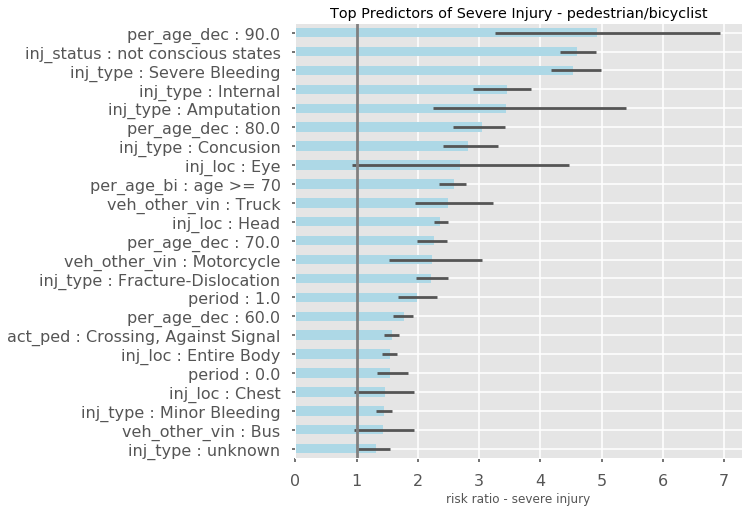

In [7]:
# plotting

errmax = sample.quantile(.95, axis =  1) - factorSev['RiskRatio']
errmin = factorSev['RiskRatio'] - sample.quantile(.05, axis =  1)
df = factorSev[factorSev.RiskRatio>1.3] #only show attributes with higher ratios
error = [[errmin[df.index],errmax[df.index]]]

df.RiskRatio.T.plot(kind='barh',xerr=error,color='lightblue',figsize=(8,8))
plt.axvline(x=1,color='grey')
plt.xlabel('severity ratio')
plt.title('Top Predictors of Severe Injury - pedestrian/bicyclist')

In [8]:
# Only pedestrians under 70

pedNotOld = ped[ped.f_per_age<70]

factorSevNotOld = riskratio(pedNotOld)

factorSevNotOld

,severeCount,allCount,severePct,RiskRatio
inj_loc : Elbow-Lower Arm-Hand,42,1464,0.028689,0.336066
inj_loc : Knee-Lower Leg-Foot,194,5159,0.037604,0.440506
inj_loc : Shoulder-Upper Arm,45,1140,0.039474,0.462406
act_veh_other : Making Right Turn,70,1626,0.043050,0.504305
inj_type : None Visible,82,1851,0.044300,0.518947
inj_loc : Back,55,1138,0.048330,0.566156
act_veh_other : Backing,53,1078,0.049165,0.575934
road_control : Stop sign,57,1151,0.049522,0.580117
inj_type : Complaint of Pain,451,8983,0.050206,0.588127
inj_type : Contusion-Bruise,72,1421,0.050669,0.593546


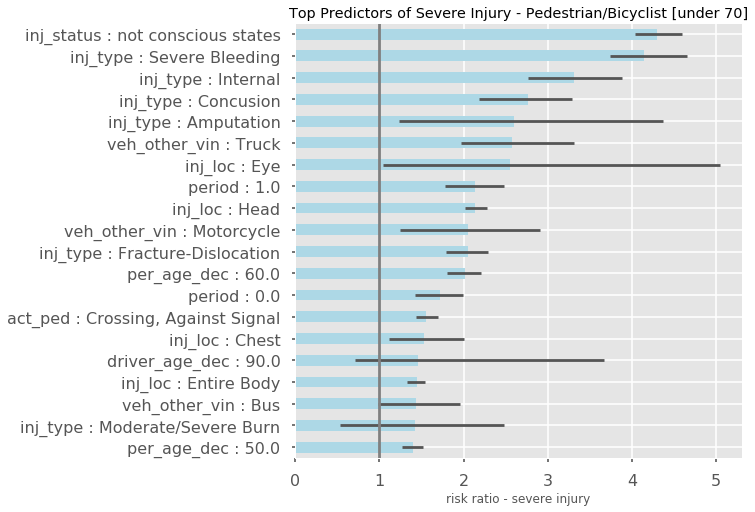

In [9]:
# bootstrapping for error bars
sample=pd.DataFrame()
for i in range(100):
    sample[i] = riskratio(pedNotOld.sample(frac=1,replace=True))['RiskRatio']

errmax = sample.quantile(.95, axis =  1) - factorSevNotOld['RiskRatio']
errmin = factorSevNotOld['RiskRatio'] - sample.quantile(.05, axis =  1)
df = factorSevNotOld[factorSevNotOld.RiskRatio>1.3]
error = [[errmin[df.index],errmax[df.index]]]

# plot
df.RiskRatio.T.plot(kind='barh',xerr=error,
                    color='lightblue',figsize=(8,8))
plt.axvline(x=1,color='grey')
plt.xlabel('risk ratio - severe injury')
plt.title('Top Predictors of Severe Injury - Pedestrian/Bicyclist [under 70]')

In [10]:
pedNotOld[pedNotOld.biss_severity_9=='severe'].shape

(1400, 105)

In [11]:
pedNotOld[pedNotOld.biss_severity_9=='severe'].shape[0]/float(pedNotOld.shape[0])

0.08536585365853659

### New KSI formula 1:  KABCO plus 
Create a dataframe that stores the precision and recall information on the various formulas.

In [5]:
ksiplus = pd.DataFrame(columns=['FracCrashes','Precision','Recall',
                                'pLow','pHigh','rLow','rHigh'])

def addRow(data, N=100,frac=1):
    ''' returns a row to add to the the ksiplus dataframe
    data = injured person data 
    N = number of samples to use for bootstrapping
    frac = fraction of data to use for resampling
    
    '''
    #precision recall
    yPred = (data.newSev=='severe').astype(int)
    yActual = (data.biss_severity_9=='severe').astype(int)
    prec, recall = an.prec_recall(y_actual=yActual,y_predict=yPred, threshold=.5)
    fracCrashes = yPred.sum()/float(yPred.shape[0])
    
    # error bars
    precSample = []
    recSample = []
    for i in range(N):
        df = data.sample(frac=frac,replace=True)

        yPred = (df.newSev=='severe').astype(int)
        yActual = (df.biss_severity_9=='severe').astype(int)

        p,r = an.prec_recall(y_actual=yActual,y_predict=yPred,threshold=.5)

        precSample.append(p)
        recSample.append(r)

    pLow,pHigh = np.percentile(precSample,5),np.percentile(precSample,95)
    rLow,rHigh = np.percentile(recSample,5),np.percentile(recSample,95)

    row=[fracCrashes, prec, recall, pLow,pHigh,rLow,rHigh]
    return row

In [6]:
# baseline: K,A from KABCO
ped['newSev'] = 'not severe'
ped.loc[ped.SEVERITY.isin(['K','A']),'newSev'] = 'severe'

ksiplus.loc['K,A']= addRow(ped,N=1000)

# 70plus: age 70+
ped['newSev'] = 'not severe'
ped.loc[ped.SEVERITY.isin(['K','A']),'newSev'] = 'severe'
ped.loc[ped.f_per_age>=70,'newSev'] = 'severe'

ksiplus.loc['K,A + age 70+']= addRow(ped,N=1000)

# head: any head injury
ped['newSev'] = 'not severe'
ped.loc[ped.SEVERITY.isin(['K','A']),'newSev'] = 'severe'
ped.loc[ped.f_inj_loc=='Head','newSev'] = 'severe'

ksiplus.loc['K,A + head injury']= addRow(ped,N=1000)

# vehicle: vehicle = Truck, Motorcycle
ped['newSev'] = 'not severe'
ped.loc[ped.SEVERITY.isin(['K','A']),'newSev'] = 'severe'
ped.loc[ped.f_veh_other_vin.isin(['Motorcycle','Truck']),'newSev'] = 'severe'

ksiplus.loc['K,A + motorcycle,truck']= addRow(ped,N=1000)

# all: all of the above
ped['newSev'] = 'not severe'
ped.loc[ped.SEVERITY.isin(['K','A']),'newSev'] = 'severe'
ped.loc[ped.f_per_age>=70,'newSev'] = 'severe'
ped.loc[ped.f_inj_loc=='Head','newSev'] = 'severe'
ped.loc[ped.f_veh_other_vin.isin(['Motorcycle','Truck']),'newSev'] = 'severe'

ksiplus.loc['all above']= addRow(ped,N=1000)


ksiplus


,FracCrashes,Precision,Recall,pLow,pHigh,rLow,rHigh
"K,A",0.137596,0.308866,0.438525,0.293378,0.325058,0.418646,0.458749
"K,A + age 70+",0.191954,0.268992,0.532787,0.256220,0.281894,0.511458,0.552414
"K,A + head injury",0.244269,0.229501,0.578454,0.219156,0.240056,0.558279,0.597584
"K,A + motorcycle,truck",0.146562,0.298103,0.450820,0.284781,0.313169,0.430769,0.470803
all above,0.295393,0.214176,0.652810,0.205503,0.223352,0.634854,0.673274


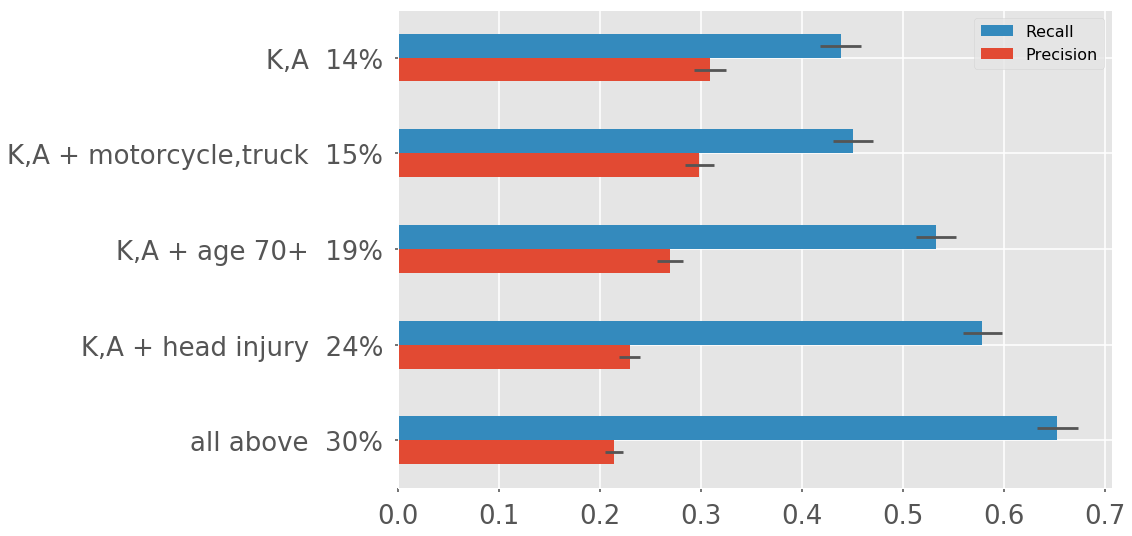

In [7]:
ksiplus.sort_values('Precision',inplace=True)
ksiplus.index = ksiplus.index +'  '\
    + (ksiplus.FracCrashes.astype(float)*100).round(0).astype(int).astype(str)+'%'

# error bars
ksiplus['pDeltaLow'] = ksiplus['Precision'] - ksiplus['pLow'] 
ksiplus['pDeltaHigh'] = ksiplus['pHigh'] - ksiplus['Precision']

ksiplus['rDeltaLow'] = ksiplus['Recall'] - ksiplus['rLow']
ksiplus['rDeltaHigh'] = ksiplus['rHigh'] - ksiplus['Recall']

perror = ksiplus[['pDeltaLow','pDeltaHigh']].T.values
rerror = ksiplus[['rDeltaHigh','rDeltaHigh']].T.values

error = [perror,rerror]

ksiplus[['Precision','Recall']].plot(kind='barh',xerr=error,fontsize=26,
                               legend='reverse')

## New KSI formula 2. Scoring Model using Logistic Regression

an.fitPlotMult() uses 80% of the data to fit a logistic regression to the data and plot out the precision recall curve calculated using the remaining 20% of the data. It also calculates the optimal recall, which is the recall given the same precision as the baseline DMV formula.

The first graph below shows the result for one run (N=1).

Running this multiple times (N=10 below for example) leads to a distribution of optimal recall. It's randomly choosing a different 80% of the data to train on. We use the distribution to identify confidence intervals.  

['f_inj_type', 'f_inj_status', 'f_inj_loc', 'f_veh_other_vin', 'f_per_age_dec']
number of variables 45
number of data points 17624
number of severe instances 1708.0
test fraction 0.2
Optimization terminated successfully.
         Current function value: 0.261482
         Iterations 8
baseline dmv 
 precision   recall
0.31          0.44
optimal recall 0.56


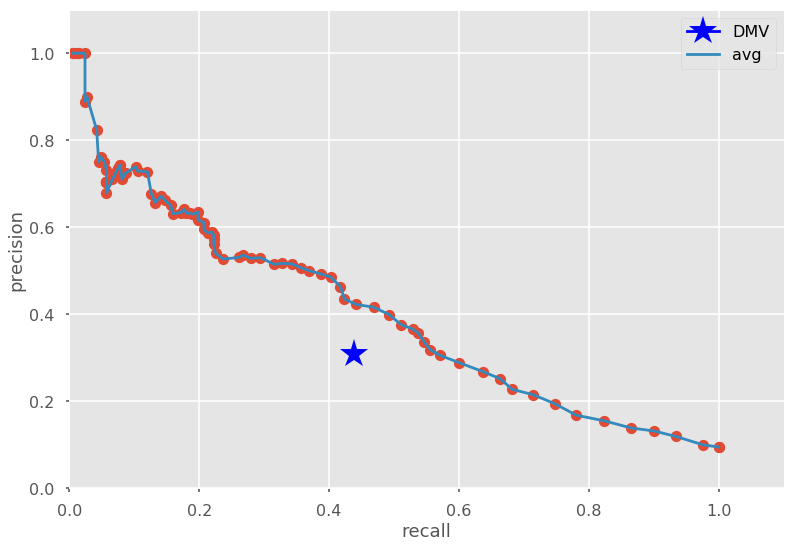

In [15]:
df = an.fitPlotMult(data=ped,pred=['f_inj_type','f_inj_status','f_inj_loc',
                                   'f_veh_other_vin','f_per_age_dec'],N=1)

['f_inj_type', 'f_inj_status', 'f_inj_loc', 'f_veh_other_vin', 'f_per_age_dec']
number of variables 45
number of data points 17624
number of severe instances 1708.0
test fraction 0.2
         Current function value: 0.260321
         Iterations: 35


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.258133
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.260096
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.264605
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.258481
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.256891
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.256211
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.257419
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.258851
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.258819
         Iterations 8
baseline dmv 
 precision   recall
0.31          0.44
optimal recall 0.55


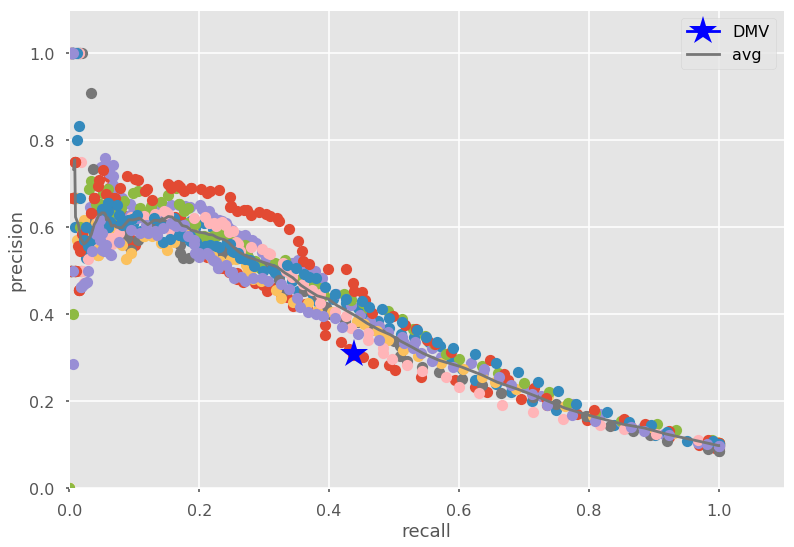

In [13]:
df = an.fitPlotMult(data=ped,pred=['f_inj_type','f_inj_status','f_inj_loc',
                                   'f_veh_other_vin','f_per_age_dec'],N=10)

In [17]:
an.median_recall(df)

('0.52', '0.47', '0.56')

['f_inj_type', 'f_inj_status', 'f_inj_loc', 'f_per_sex', 'f_driver_sex', 'f_per_age_dec', 'f_driver_age_dec', 'f_per_role', 'f_per_eject', 'f_per_loc', 'f_road_light', 'f_period', 'f_road_surf', 'f_road_weather', 'f_road_control', 'f_act_ped', 'f_act_veh_other', 'f_veh_other_vin']
number of variables 94
number of data points 17624
number of severe instances 1708.0
test fraction 0.2
         Current function value: 0.252523
         Iterations: 35


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.253453
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.248752
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.255451
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.256181
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.252226
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.252242
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.255449
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.254642
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.252093
         Iterations 8
baseline dmv 
 precision   recall
0.31          0.44
optimal recall 0.55


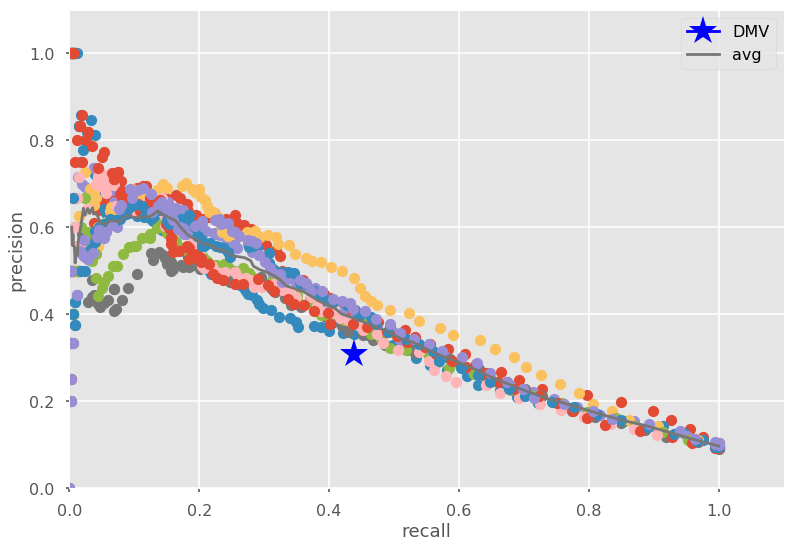

In [11]:
# include all the variables

var = list(ped.filter(like='f_').columns)
remove = ['f_per_age','f_per_age_bi','f_driver_age','f_driver_age_bi']
allvar = [x for x in var if x not in remove]

df = an.fitPlotMult(data=ped,pred=allvar,N=10)

In [14]:
df

,index,precision,recall
0,0.19,0.319635,0.430769
1,0.14,0.327815,0.570605
2,0.14,0.323232,0.558140
3,0.17,0.325630,0.509868
4,0.15,0.317291,0.514451
5,0.13,0.309144,0.580381
6,0.15,0.311234,0.482857
7,0.12,0.312680,0.588076
8,0.13,0.323077,0.591549
9,0.15,0.310287,0.541176


### Variable Selection
This will help decide which variables (attributes) to use in the final formula. If more variables don't lead to better recall metric, we don't need them in the model.

The method here will be to start with the three injury variables and then add in 2 more of the 15 other variables (15 choose 2 combinations). Calculate the optimal recall for all variations. Choose the model with the highest optimal recall. We're limiting it to 2 because otherwise the number of combinations becomes intractable. 

Note: Forward and backward selection was tried but did not work well. We re-evaluated and decided to do this 2 variable selection instead.

In [18]:
#baseline recall
y_actual = (ped.biss_severity_9=='severe').astype(int)
y_pred = (ped.SEVERITY.isin(['K','A'])).astype(int)
basePrec, baseRecall = an.prec_recall(y_actual=y_actual,y_predict=y_pred,threshold=.5)

print basePrec,baseRecall

0.3088659793814433 0.4385245901639344


In [19]:
# list all variables, only remove injury variables and redundant age variables

var = list(ped.filter(like='f_').columns)
remove = ['f_inj_type','f_inj_loc','f_inj_status',
          'f_per_age','f_per_age_bi','f_driver_age','f_driver_age_bi',
         #'f_road_light','f_road_control',
          #'f_per_sex',
          #'f_driver_sex',
          #'f_road_surf','f_ped_loc','f_per_role','f_per_loc',
         ]

varOfInt = [x for x in var if x not in remove]
varOfInt

['f_per_sex',
 'f_driver_sex',
 'f_per_age_dec',
 'f_driver_age_dec',
 'f_per_role',
 'f_per_eject',
 'f_per_loc',
 'f_road_light',
 'f_period',
 'f_road_surf',
 'f_road_weather',
 'f_road_control',
 'f_act_ped',
 'f_act_veh_other',
 'f_veh_other_vin']

Run all combinations of variable pairs. 
Add pairs to baseline injury variables. 
Capture precision and recall 

In [20]:
%%capture
# set up dataframe to collect recall info for all the models
models = pd.DataFrame(columns=['model','recall','recall low','recall high'])

# injury variables all models will have
inj=['f_inj_type','f_inj_status','f_inj_loc']

# adding additional variable pairs and calculating recall
for x in list(itertools.combinations(varOfInt,2)):
    pred = inj + [x[0],x[1]]
    op = an.fitPlotMult(data=ped, pred=pred, N=100)
    models = models.append([{'model':'+'.join([x[0],x[1]]),
                            'recall':float(an.median_recall(op)[0]),
                            'recall low':float(an.median_recall(op)[1]),
                            'recall high': float(an.median_recall(op)[2]),
                            }],
                            ignore_index=True)
models.index = models.model
models.drop('model',axis=1,inplace=True)

#clean up model names
models.index = models.index.str.replace('f_','').str.replace('dec','')\
.str.replace('period','time').str.replace('road_','')

# error bars for graph
models['delta low'] = models['recall low'] - models['recall']
models['delta high'] = models['recall high'] - models['recall']
error = models[['delta low','delta high']].T.values


In [21]:
models

,recall,recall low,recall high,delta low,delta high
model,,,,,
per_sex+driver_sex,0.46,0.40,0.53,-0.06,0.07
per_sex+per_age_,0.53,0.48,0.58,-0.05,0.05
per_sex+driver_age_,0.48,0.40,0.53,-0.08,0.05
per_sex+per_role,0.47,0.42,0.53,-0.05,0.06
per_sex+per_eject,0.46,0.40,0.51,-0.06,0.05
per_sex+per_loc,0.46,0.39,0.50,-0.07,0.04
per_sex+light,0.46,0.42,0.52,-0.04,0.06
per_sex+time,0.47,0.42,0.52,-0.05,0.05
per_sex+surf,0.46,0.41,0.51,-0.05,0.05


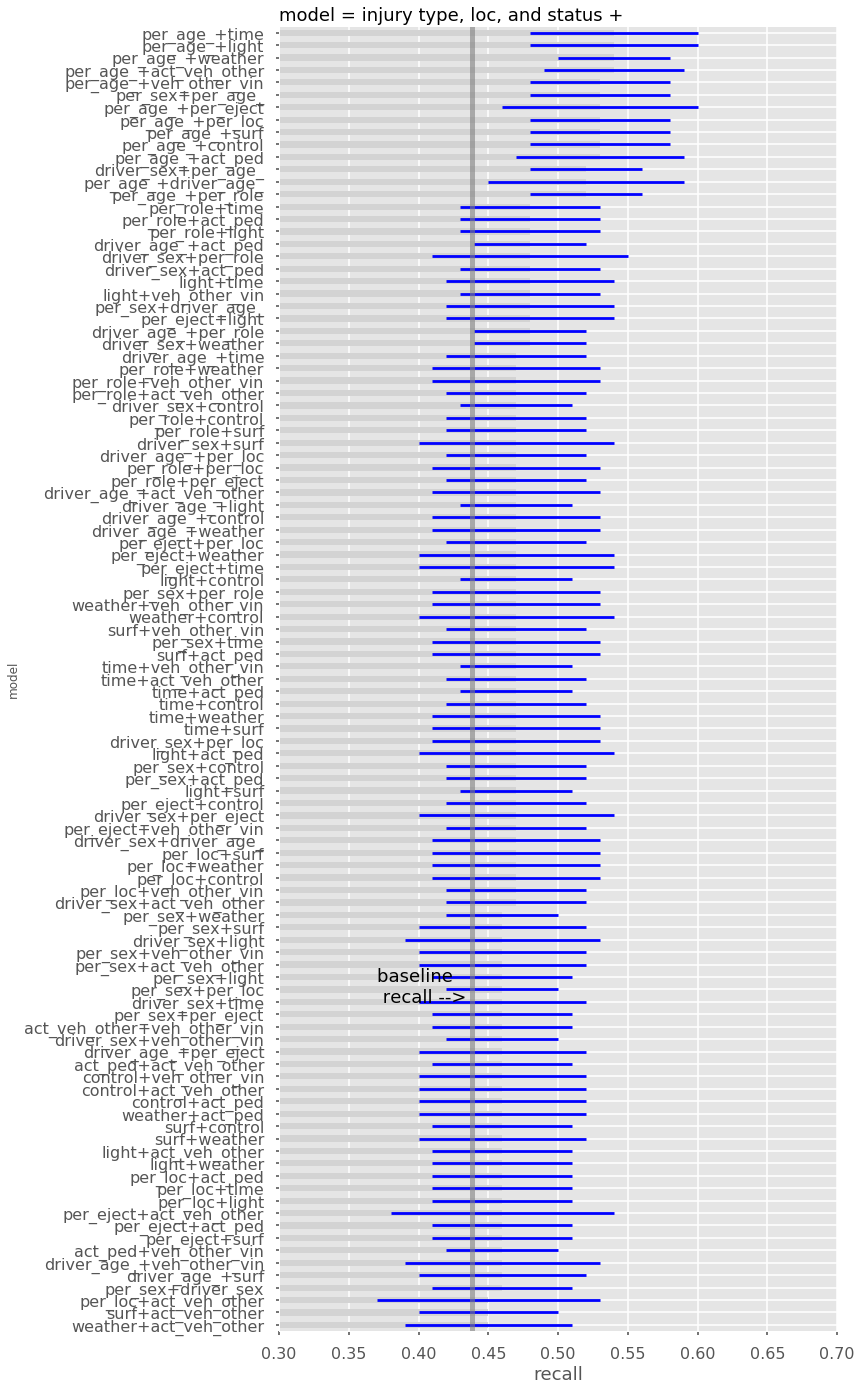

In [22]:
#plot
models[['recall']].sort_values('recall').plot(kind='barh',
                                              color='lightgrey',
                                              #edgecolor='black',
                                              ecolor='blue',
                                              xerr=error, figsize=(10,24),
                                              legend=False,xlim=(.3,.7))
plt.title('model = injury type, loc, and status +',fontsize=18,loc='left')
plt.xlabel('recall',fontsize=18)
plt.axvline(baseRecall, color ='grey', linewidth=5,alpha=.6)
plt.text(.37,26,'baseline \n recall -->',fontsize=18)

All models where the optimal recall is clearly greater then the baseline (KABCO) recall are shown below. All of them have age as one of the variables in the model.

In [23]:
models[models['recall low']>baseRecall]

,recall,recall low,recall high,delta low,delta high
model,,,,,
per_sex+per_age_,0.53,0.48,0.58,-0.05,0.05
driver_sex+per_age_,0.52,0.47,0.59,-0.05,0.07
per_age_+driver_age_,0.52,0.48,0.57,-0.04,0.05
per_age_+per_role,0.52,0.47,0.59,-0.05,0.07
per_age_+per_eject,0.53,0.47,0.59,-0.06,0.06
per_age_+per_loc,0.53,0.47,0.58,-0.06,0.05
per_age_+light,0.54,0.47,0.59,-0.07,0.05
per_age_+time,0.54,0.48,0.59,-0.06,0.05
per_age_+surf,0.53,0.49,0.57,-0.04,0.04


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


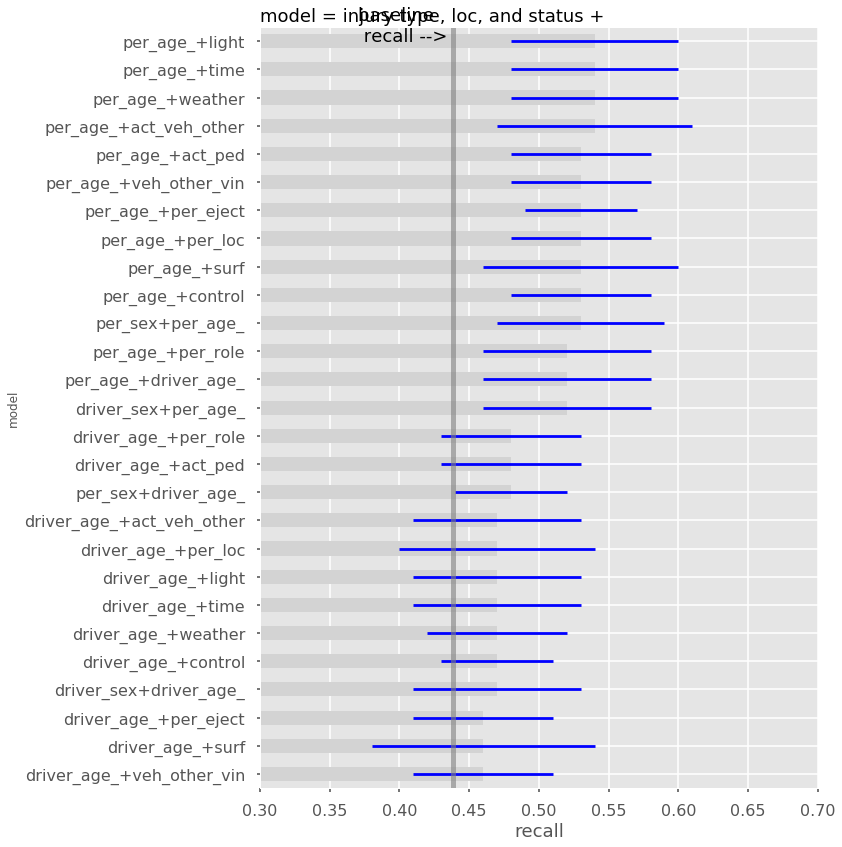

In [24]:
# look more closely at the age variables
md = models[models.index.str.contains('age')]

# error bars
md['delta low'] = md['recall low'] - md['recall']
md['delta high'] = md['recall high'] - md['recall']
error = md[['delta low','delta high']].T.values

md[['recall']].sort_values('recall').plot(kind='barh',
                                              color='lightgrey',
                                              #edgecolor='black',
                                              ecolor='blue',
                                              xerr=error, figsize=(10,14),
                                              legend=False,xlim=(.3,.7))
plt.title('model = injury type, loc, and status +',fontsize=18,loc='left')
plt.xlabel('recall',fontsize=18)
plt.axvline(baseRecall, color ='grey', linewidth=5,alpha=.6)
plt.text(.37,26,'baseline \n recall -->',fontsize=18)

### try again with a limited set of variables for easy graphing


In [25]:
# try again with a limited set of variables for easy graphing
var = list(ped.filter(like='f_').columns)
remove = ['f_inj_type','f_inj_loc','f_inj_status',
          'f_per_age','f_per_age_bi','f_driver_age','f_driver_age_bi',
          'f_road_light','f_road_control',
          #'f_per_sex',
          'f_driver_sex',
          'f_road_surf','f_ped_loc','f_per_role','f_per_loc',
          'f_per_eject'
         ]

varOfInt = [x for x in var if x not in remove]
varOfInt

['f_per_sex',
 'f_per_age_dec',
 'f_driver_age_dec',
 'f_period',
 'f_road_weather',
 'f_act_ped',
 'f_act_veh_other',
 'f_veh_other_vin']

In [26]:
%%capture
models2 = pd.DataFrame(columns=['model','recall','recall low','recall high'])
inj=['f_inj_type','f_inj_status','f_inj_loc']

for x in list(itertools.combinations(varOfInt,2)):
    pred = inj + [x[0],x[1]]
    op = an.fitPlotMult(data=ped, pred=pred, N=100)
    models2 = models2.append([{'model':'+'.join([x[0],x[1]]),
                            'recall':float(an.median_recall(op)[0]),
                            'recall low':float(an.median_recall(op)[1]),
                            'recall high': float(an.median_recall(op)[2]),
                            }],
                            ignore_index=True)
models2.index = models2.model
models2.drop('model',axis=1,inplace=True)

#clean up model names
models2.index = models2.index.str.replace('f_','').str.replace('dec','')\
.str.replace('period','time').str.replace('road_','')

In [27]:
models2

,recall,recall low,recall high
model,,,
per_sex+per_age_,0.53,0.47,0.59
per_sex+driver_age_,0.46,0.41,0.52
per_sex+time,0.47,0.41,0.51
per_sex+weather,0.46,0.40,0.51
per_sex+act_ped,0.48,0.42,0.52
per_sex+act_veh_other,0.46,0.42,0.52
per_sex+veh_other_vin,0.47,0.42,0.52
per_age_+driver_age_,0.53,0.47,0.58
per_age_+time,0.53,0.48,0.58


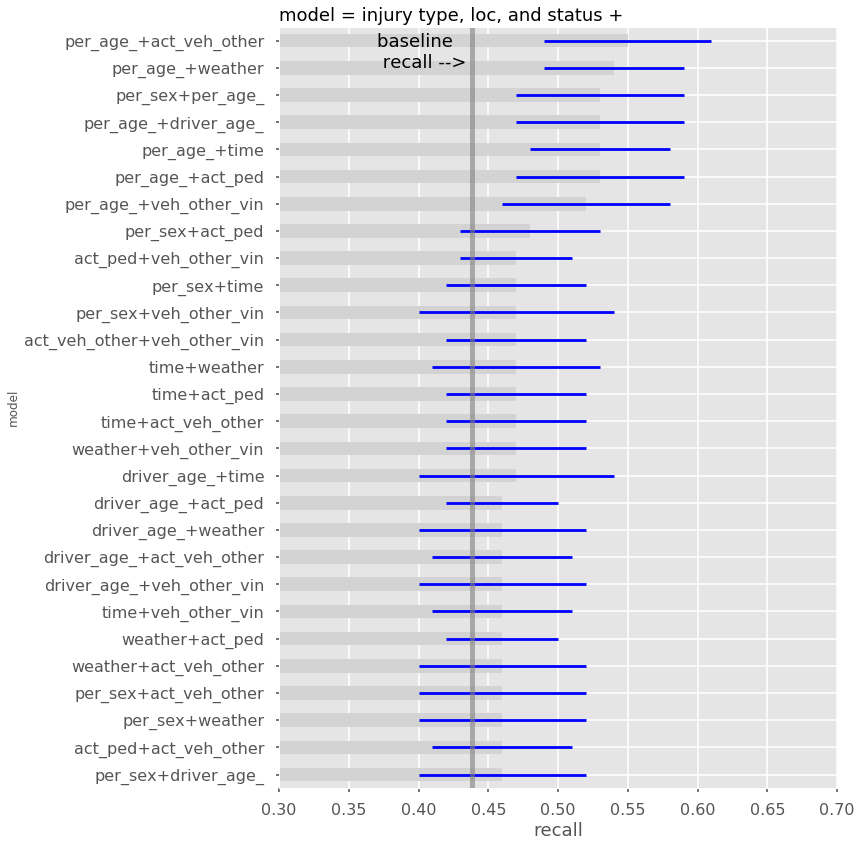

In [28]:
# error bars
models2['delta low'] = models2['recall low'] - models2['recall']
models2['delta high'] = models2['recall high'] - models2['recall']
error2 = models2[['delta low','delta high']].T.values

# plot
models2[['recall']].sort_values('recall').plot(kind='barh',
                                              color='lightgrey',
                                              #edgecolor='black',
                                              ecolor='blue',
                                              xerr=error2, figsize=(10,14),
                                              legend=False,xlim=(.3,.7))
plt.title('model = injury type, loc, and status +',fontsize=18,loc='left')
plt.xlabel('recall',fontsize=18)
plt.axvline(baseRecall, color ='grey', linewidth=5,alpha=.6)
plt.text(.37,26,'baseline \n recall -->',fontsize=18)

['f_inj_type', 'f_inj_status', 'f_inj_loc', 'f_per_age_dec']
number of variables 37
number of data points 17624
number of severe instances 1708.0
test fraction 0.2
Optimization terminated successfully.
         Current function value: 0.259325
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.262816
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.261815
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.261668
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.260585
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.259475
         Iterations 8
         Current function value: 0.258158
         Iterations: 35


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.255168
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.257164
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.259018
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.261457
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.257600
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.263078
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.259239
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.258481
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.262578
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.262091
  

/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.263248
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.259062
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.257437
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.254108
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.263255
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.256103
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.258008
         Iterations 8
         Current function value: 0.258800
         Iterations: 35


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.259431
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.263497
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.261698
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.260617
         Iterations 8
         Current function value: 0.255346
         Iterations: 35


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.259813
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.261182
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.259382
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.261243
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.256434
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.262970
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.260302
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.261377
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.257467
         Iterations 8
         Current function value: inf
         Iterations: 35
error - singular matr

,delta high,delta low,recall,recall high,recall low
per_sex+per_age_,0.06,-0.06,0.53,0.59,0.47
per_sex+driver_age_,0.06,-0.05,0.46,0.52,0.41
per_sex+time,0.04,-0.06,0.47,0.51,0.41
per_sex+weather,0.05,-0.06,0.46,0.51,0.40
per_sex+act_ped,0.04,-0.06,0.48,0.52,0.42
per_sex+act_veh_other,0.06,-0.04,0.46,0.52,0.42
per_sex+veh_other_vin,0.05,-0.05,0.47,0.52,0.42
per_age_+driver_age_,0.05,-0.06,0.53,0.58,0.47
per_age_+time,0.05,-0.05,0.53,0.58,0.48
per_age_+weather,0.04,-0.06,0.54,0.58,0.48


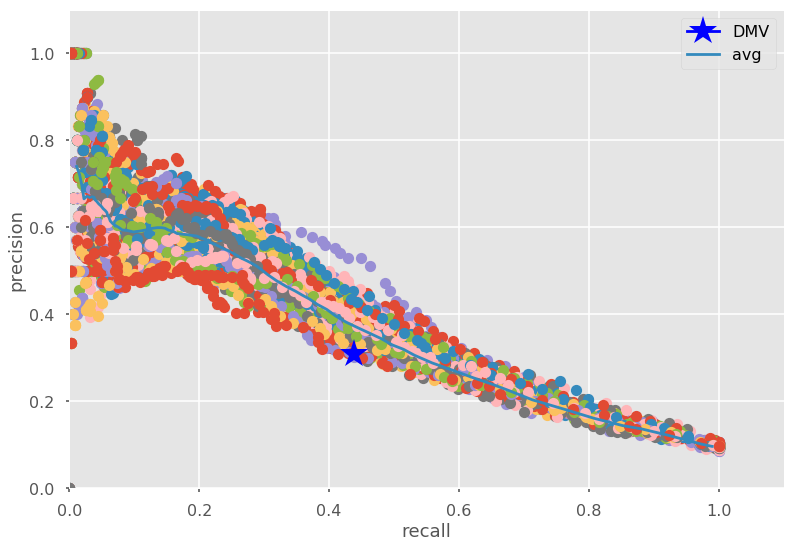

In [29]:
%%capture

# let's do only age by itself (with inj vars)

pred=['f_inj_type','f_inj_status','f_inj_loc','f_per_age_dec']

op = an.fitPlotMult(data=ped, pred=pred, N=100)
an.median_recall(op)

# add onto models2 dataframe
r = float(an.median_recall(op)[0])
rl = float(an.median_recall(op)[1])
rh = float(an.median_recall(op)[2])

models2 = models2.append(pd.DataFrame(data=[{
                'recall':r,
                'recall low':rl,
                'recall high':rh,
                'delta low':rl-r,
                'delta high':rh-r
                }],index=['per_age']))
models2

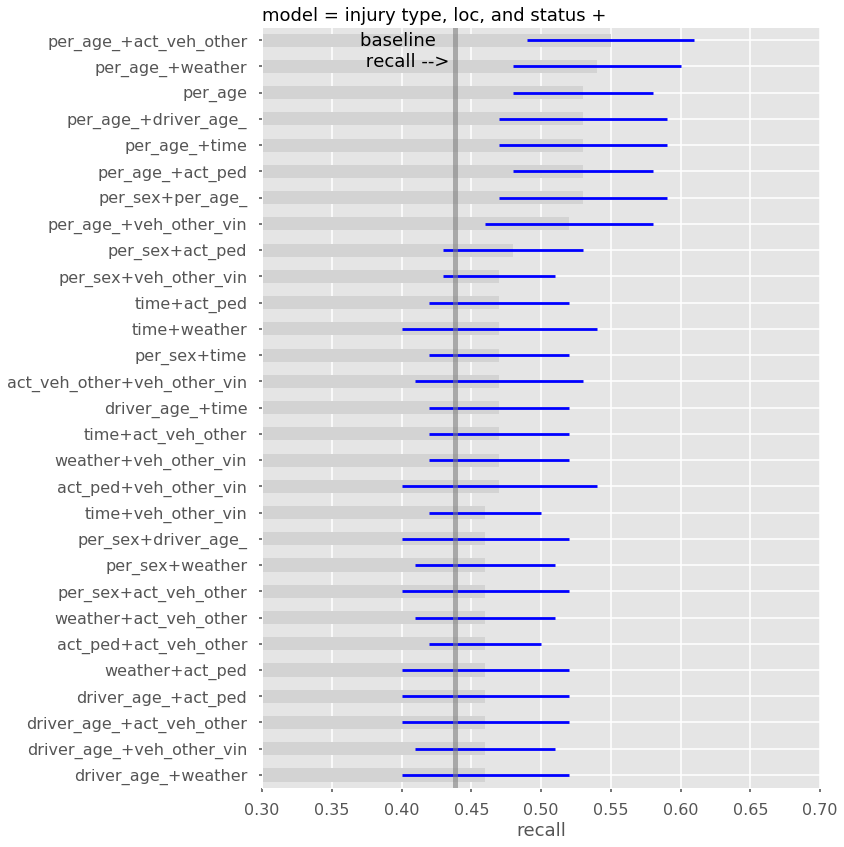

In [30]:
# error bars
models2['delta low'] = models2['recall low'] - models2['recall']
models2['delta high'] = models2['recall high'] - models2['recall']
error2 = models2[['delta low','delta high']].T.values

# plot
models2[['recall']].sort_values('recall').plot(kind='barh',
                                              color='lightgrey',
                                              #edgecolor='black',
                                              ecolor='blue',
                                              xerr=error2, figsize=(10,14),
                                              legend=False,xlim=(.3,.7))
plt.title('model = injury type, loc, and status +',fontsize=18,loc='left')
plt.xlabel('recall',fontsize=18)
plt.axvline(baseRecall, color ='grey', linewidth=5,alpha=.6)
plt.text(.37,27,'baseline \n recall -->',fontsize=18)

In [37]:
# redo with age under 60

pedUnder60 = ped[ped.f_per_age<60]

print pedUnder60.shape
print pedUnder60[pedUnder60.biss_severity_9=='severe'].shape

(14974, 106)
(1154, 106)


In [38]:
# try again with only age < 60
# a limited set of variables for easy graphing
var = list(ped.filter(like='f_').columns)
remove = ['f_inj_type','f_inj_loc','f_inj_status',
          'f_per_age','f_per_age_bi','f_driver_age','f_driver_age_bi',
          'f_road_light','f_road_control',
          #'f_per_sex',
          'f_driver_sex',
          'f_road_surf','f_ped_loc','f_per_role','f_per_loc',
          'f_per_eject'
         ]

varOfInt = [x for x in var if x not in remove]
varOfInt

['f_per_sex',
 'f_per_age_dec',
 'f_driver_age_dec',
 'f_period',
 'f_road_weather',
 'f_act_ped',
 'f_act_veh_other',
 'f_veh_other_vin']

In [39]:
%%capture
modelsUnder60 = pd.DataFrame(columns=['model','recall','recall low','recall high'])
inj=['f_inj_type','f_inj_status','f_inj_loc']

for x in list(itertools.combinations(varOfInt,2)):
    pred = inj + [x[0],x[1]]
    op = an.fitPlotMult(data=pedUnder60, pred=pred, N=100)
    modelsUnder60 = modelsUnder60.append([{'model':'+'.join([x[0],x[1]]),
                            'recall':float(an.median_recall(op)[0]),
                            'recall low':float(an.median_recall(op)[1]),
                            'recall high': float(an.median_recall(op)[2]),
                            }],
                            ignore_index=True)
modelsUnder60.index = modelsUnder60.model
modelsUnder60.drop('model',axis=1,inplace=True)

#clean up model names
modelsUnder60.index = modelsUnder60.index.str.replace('f_','').str.replace('dec','')\
.str.replace('period','time').str.replace('road_','')

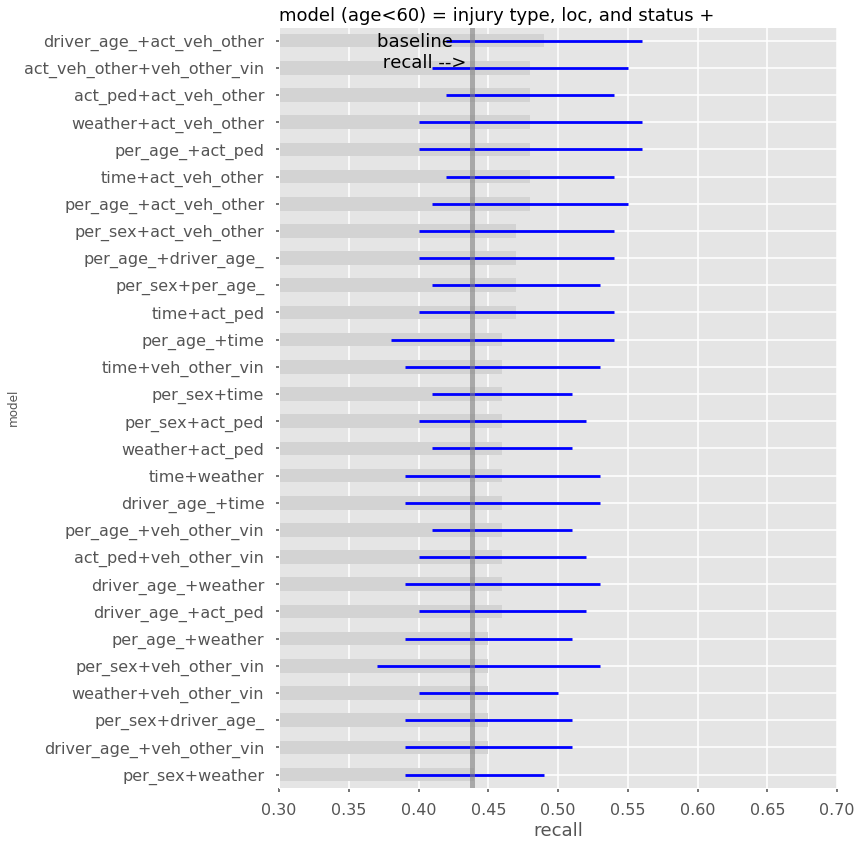

In [40]:
# error bars
modelsUnder60['delta low'] = modelsUnder60['recall low'] - modelsUnder60['recall']
modelsUnder60['delta high'] = modelsUnder60['recall high'] - modelsUnder60['recall']
error = modelsUnder60[['delta low','delta high']].T.values

# plot
modelsUnder60[['recall']].sort_values('recall').plot(kind='barh',
                                              color='lightgrey',
                                              #edgecolor='black',
                                              ecolor='blue',
                                              xerr=error, figsize=(10,14),
                                              legend=False,xlim=(.3,.7))
plt.title('model (age<60) = injury type, loc, and status +',fontsize=18,loc='left')
plt.xlabel('recall',fontsize=18)
plt.axvline(baseRecall, color ='grey', linewidth=5,alpha=.6)
plt.text(.37,26,'baseline \n recall -->',fontsize=18)

### Logit Model Coefficients

Optimization terminated successfully.
         Current function value: 0.260030
         Iterations 8


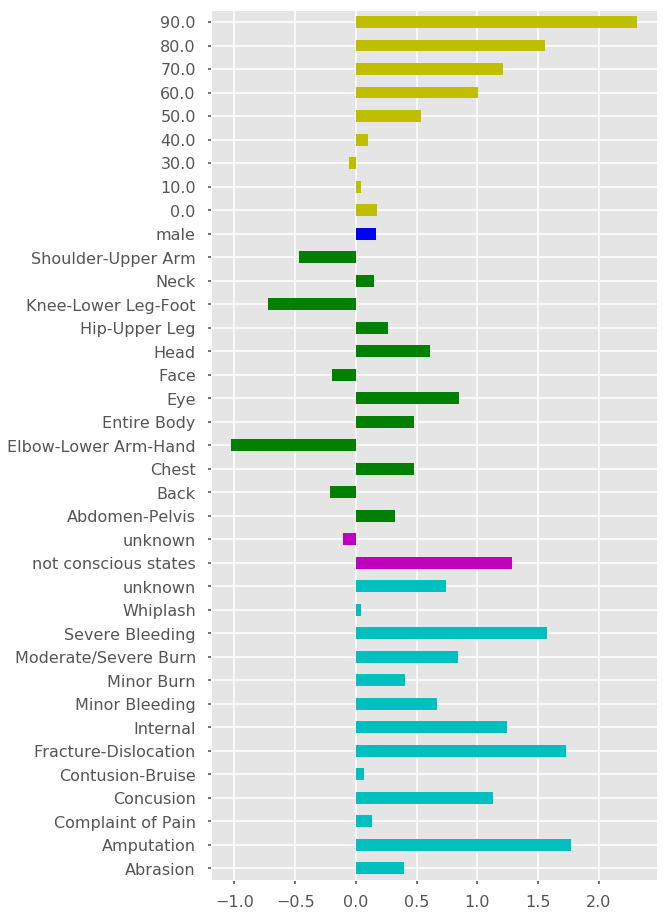

In [55]:
# set up X and y 
pred = ["C(f_inj_type,Treatment(reference='None Visible'))", 
        "C(f_inj_status,Treatment(reference='conscious states'))", 
        "C(f_inj_loc,Treatment(reference='unknown'))",
        "C(f_per_sex,Treatment(reference='female'))",
        "C(f_per_age_dec,Treatment(reference='20.0'))"
       ]
        
y,X = dmatrices('biss_severity_9' + '~' + '+'.join(pred),
                    ped, return_type='dataframe')
y = np.ravel(y['biss_severity_9[severe]'])

X.columns = X.columns.str[2:].str.split('\)\)\[T.').str.get(1).str[:-1]

# fit model
model = sm.Logit(y,X).fit()

# plot coefficients
colors = ['c']*13+['m']*2+['g']*12+['b']*1 + ['y']*10
model.params[1:].plot(kind='barh',figsize=(8,16),color=colors)

In [56]:
threshold = .13
Intercept = model.params[0]

np.log(threshold/(1-threshold)) - Intercept

1.3938703597523023

Optimization terminated successfully.
         Current function value: 0.259716
         Iterations 8


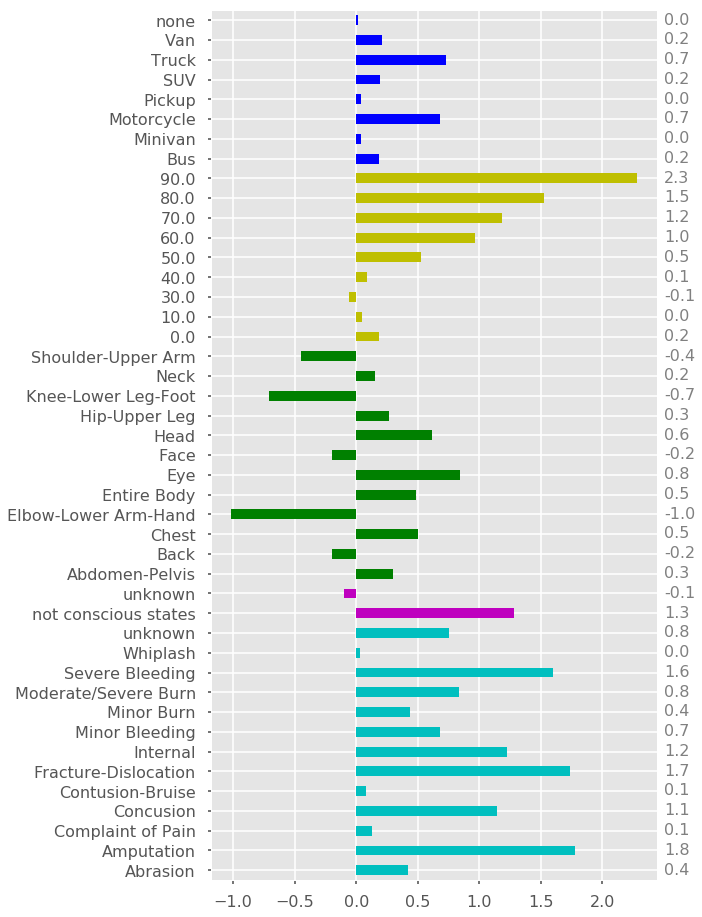

In [59]:
# set up X and y
pred = ["C(f_inj_type,Treatment(reference='None Visible'))", 
        "C(f_inj_status,Treatment(reference='conscious states'))", 
        "C(f_inj_loc,Treatment(reference='unknown'))",
#        "C(f_driver_sex,Treatment(reference='female'))",
        "C(f_per_age_dec,Treatment(reference='20.0'))",
        "C(f_veh_other_vin,Treatment(reference='Car'))",
#        "C(f_act_veh,Treatment(reference='unknown'))",

       ]
        
y,X = dmatrices('biss_severity_9' + '~' + '+'.join(pred),
                    ped, return_type='dataframe')
y = np.ravel(y['biss_severity_9[severe]'])

X.columns = X.columns.str[2:].str.split('\)\)\[T.').str.get(1).str[:-1]

# fit model
model = sm.Logit(y,X).fit()

# plot coefficients
colors = ['c']*13+['m']*2+['g']*12 + ['y']*9 + ['b']*10
model.params[1:].plot(kind='barh',figsize=(8,16),color=colors)

# print out coefficient values (rounded off)
coeff = model.params[1:].tolist()
coeff = [round(x,1) for x in coeff]

for i, v in enumerate(coeff):
    plt.text(2.5 , i - .2 , str(v),fontsize=16,color='grey')

In [58]:
threshold = .13
Intercept = model.params[0]

np.log(threshold/(1-threshold)) - Intercept

1.3632211398988932

Optimization terminated successfully.
         Current function value: 0.257778
         Iterations 8


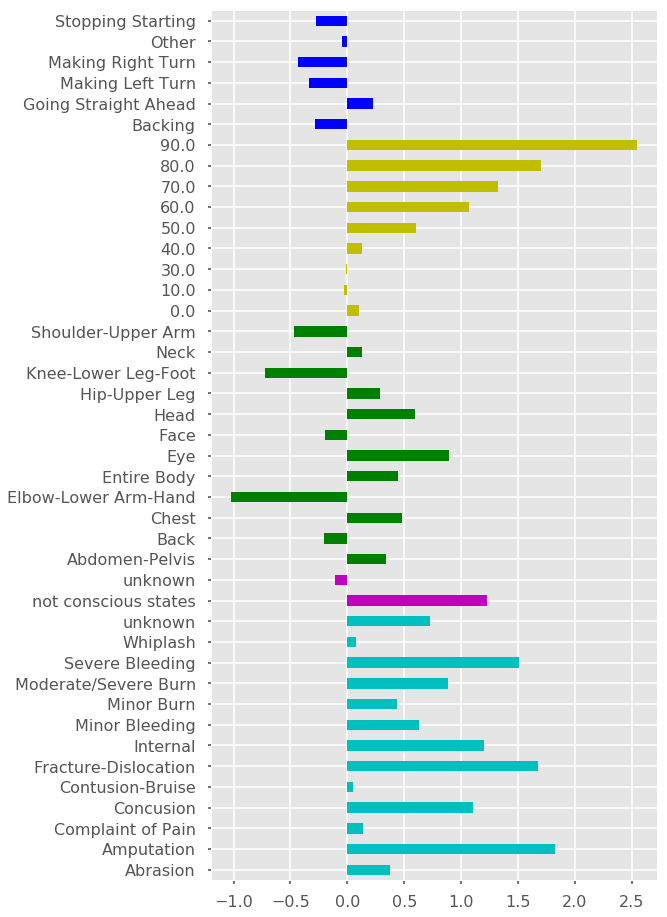

In [59]:
# set up X and y
pred = ["C(f_inj_type,Treatment(reference='None Visible'))", 
        "C(f_inj_status,Treatment(reference='conscious states'))", 
        "C(f_inj_loc,Treatment(reference='unknown'))",
#        "C(f_driver_sex,Treatment(reference='female'))",
        "C(f_per_age_dec,Treatment(reference='20.0'))",
#        "C(f_veh_other,Treatment(reference='Car'))",
        "C(f_act_veh_other,Treatment(reference='unknown'))",

       ]
        
y,X = dmatrices('biss_severity_9' + '~' + '+'.join(pred),
                    ped, return_type='dataframe')
y = np.ravel(y['biss_severity_9[severe]'])

X.columns = X.columns.str[2:].str.split('\)\)\[T.').str.get(1).str[:-1]

# fit model
model = sm.Logit(y,X).fit()

# plot coefficients
colors = ['c']*13+['m']*2+['g']*12 + ['y']*9 + ['b']*10
model.params[1:].plot(kind='barh',figsize=(8,16),color=colors)

In [60]:
threshold = .13
Intercept = model.params[0]

np.log(threshold/(1-threshold)) - Intercept

1.270381081177864

Optimization terminated successfully.
         Current function value: 0.260259
         Iterations 8


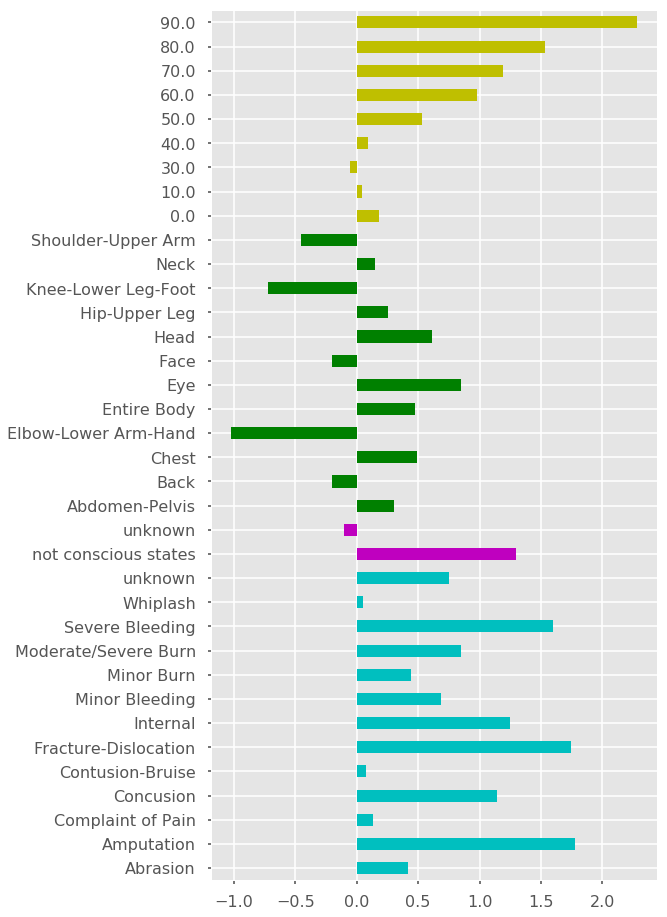

In [61]:
# set up X and y
pred = ["C(f_inj_type,Treatment(reference='None Visible'))", 
        "C(f_inj_status,Treatment(reference='conscious states'))", 
        "C(f_inj_loc,Treatment(reference='unknown'))",
#        "C(f_driver_sex,Treatment(reference='female'))",
        "C(f_per_age_dec,Treatment(reference='20.0'))",
#        "C(f_veh_other,Treatment(reference='Car'))",
#        "C(f_act_veh_other,Treatment(reference='unknown'))",

       ]
        
y,X = dmatrices('biss_severity_9' + '~' + '+'.join(pred),
                    ped, return_type='dataframe')
y = np.ravel(y['biss_severity_9[severe]'])

X.columns = X.columns.str[2:].str.split('\)\)\[T.').str.get(1).str[:-1]

# fit model
model = sm.Logit(y,X).fit()

# plot coefficients
colors = ['c']*13+['m']*2+['g']*12 + ['y']*9 + ['b']*10
model.params[1:].plot(kind='barh',figsize=(8,16),color=colors)

In [62]:
threshold = .13
Intercept = model.params[0]

np.log(threshold/(1-threshold)) - Intercept

1.3035232464377868

Optimization terminated successfully.
         Current function value: 0.258798
         Iterations 8


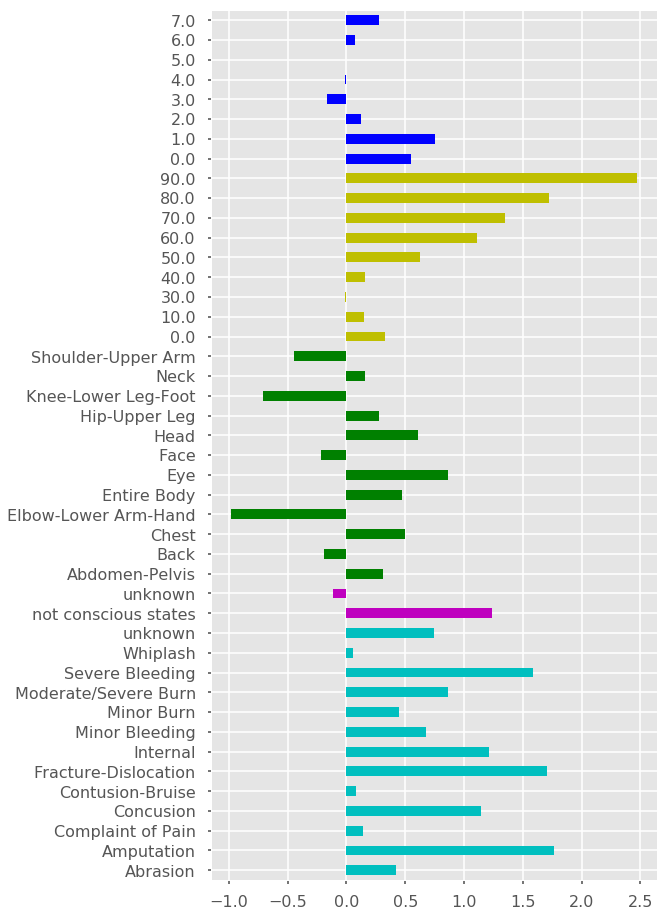

In [63]:
# set up X and y
pred = ["C(f_inj_type,Treatment(reference='None Visible'))", 
        "C(f_inj_status,Treatment(reference='conscious states'))", 
        "C(f_inj_loc,Treatment(reference='unknown'))",
#        "C(f_driver_sex,Treatment(reference='female'))",
        "C(f_per_age_dec,Treatment(reference='20.0'))",
#        "C(f_veh_other,Treatment(reference='Car'))",
#        "C(f_act_veh_other,Treatment(reference='unknown'))",
        "C(f_period,Treatment(reference='unknown'))",

       ]
        
y,X = dmatrices('biss_severity_9' + '~' + '+'.join(pred),
                    ped, return_type='dataframe')
y = np.ravel(y['biss_severity_9[severe]'])

X.columns = X.columns.str[2:].str.split('\)\)\[T.').str.get(1).str[:-1]

# fit model
model = sm.Logit(y,X).fit()

# plot coefficients
colors = ['c']*13+['m']*2+['g']*12 + ['y']*9 + ['b']*10
model.params[1:].plot(kind='barh',figsize=(8,16),color=colors)

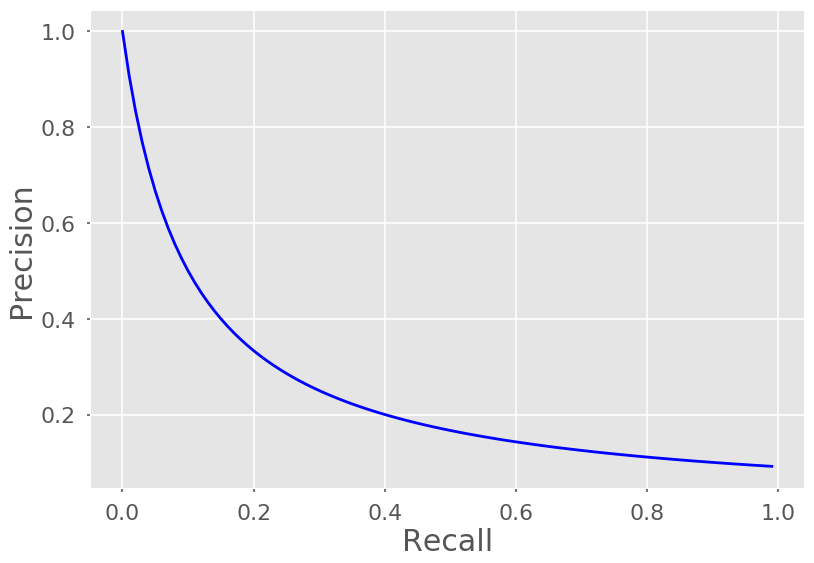

In [64]:
# fake precision - recall curve for presentation slides

t = np.arange(0.0, 1.0, 0.01)
plt.plot(t, .001/(.01*t+.001),'blue')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Recall',fontsize=30)
plt.ylabel('Precision',fontsize=30)